# 프로젝트 : CAM을 만들고 평가해보자

In [1]:
# module import
import os
import copy
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

## (1) 데이터셋 준비하기

In [2]:
# load datasets
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

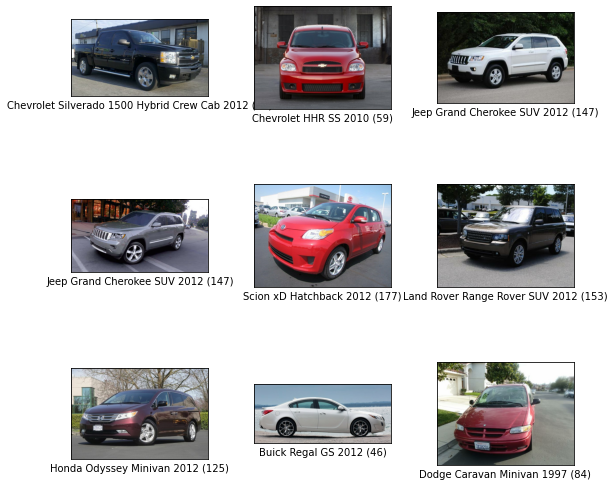

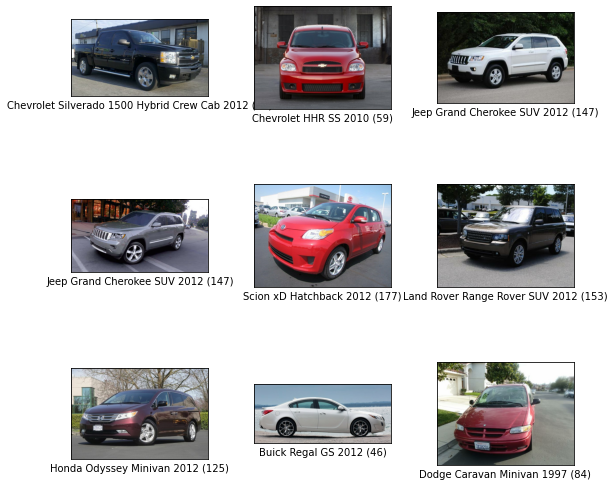

In [3]:
# check train data 
tfds.show_examples(ds_train, ds_info)

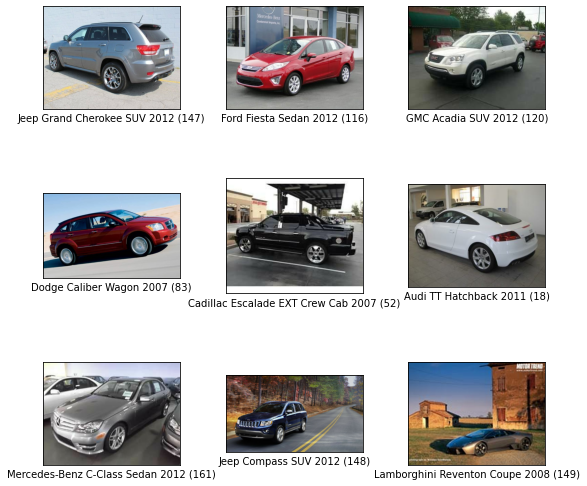

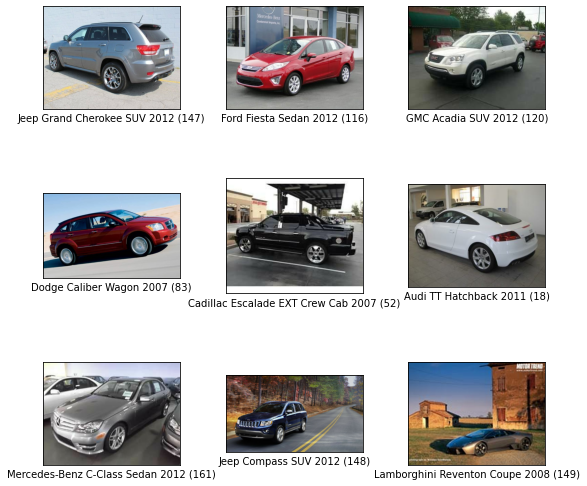

In [4]:
# check test data
tfds.show_examples(ds_test, ds_info)

## (2) 물체의 위치정보

In [5]:
# check datasets features
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## (3) CAM을 위한 모델 만들기

In [15]:
ds_info

tfds.core.DatasetInfo(
    name='cars196',
    full_name='cars196/2.0.0',
    description="""
    The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
    """,
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    data_path='/home/ssac10/tensorflow_datasets/cars196/2.0.0',
    download_size=1.82 GiB,
    dataset_size=1.85 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=8041, num_shards=8>,
        'train': <SplitInfo num_examples=8144, num_shards=8>,
 

In [6]:
num_classes = ds_info.features['label'].num_classes
base_model = tf.keras.applications.resnet.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3), 
    pooling='avg',
)
x = base_model.output
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = tf.keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [26]:
def normalize_and_resize_image(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [27]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_image,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [29]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [30]:
tf.random.set_seed(42)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [31]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 81s 158ms/step - loss: 4.1660 - accuracy: 0.1686 - val_loss: 5.4313 - val_accuracy: 0.0081
Epoch 2/15
509/509 [==============================] - 97s 191ms/step - loss: 1.6167 - accuracy: 0.6513 - val_loss: 2.3844 - val_accuracy: 0.4086
Epoch 3/15
509/509 [==============================] - 80s 158ms/step - loss: 0.5786 - accuracy: 0.8983 - val_loss: 1.3167 - val_accuracy: 0.6546
Epoch 4/15
509/509 [==============================] - 81s 158ms/step - loss: 0.1921 - accuracy: 0.9821 - val_loss: 1.0792 - val_accuracy: 0.7180
Epoch 5/15
509/509 [==============================] - 81s 159ms/step - loss: 0.0712 - accuracy: 0.9964 - val_loss: 1.0389 - val_accuracy: 0.7225
Epoch 6/15
509/509 [==============================] - 81s 159ms/step - loss: 0.0405 - accuracy: 0.9979 - val_loss: 0.9960 - val_accuracy: 0.7315
Epoch 7/15
509/509 [==============================] - 81s 159ms/step - loss: 0.0287 - accuracy: 0.9975 - val_loss: 0.9926 - val_ac

In [32]:
cam_model_path = './cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행
import os
import copy
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2
from PIL import Image
import urllib3

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_image(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [3]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

12


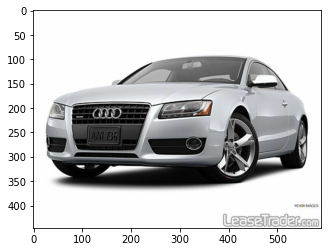

In [4]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [5]:
cam_model_path = './cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [6]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## CAM 구현하기

In [7]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_image(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = tf.squeeze(conv_outputs, axis=0)
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

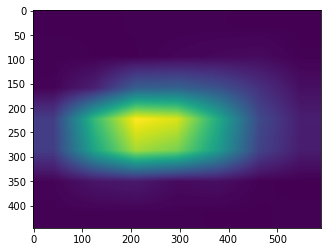

In [8]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [9]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [10]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

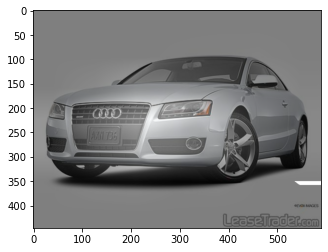

In [12]:
cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

In [13]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_image(item)
    
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, axis=0))
        
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

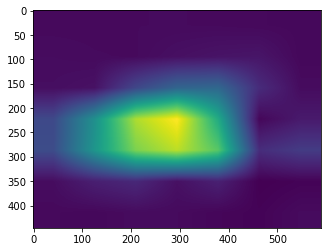

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

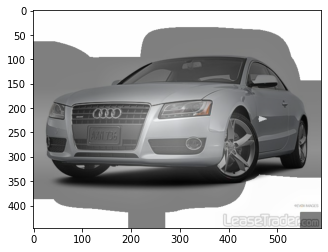

In [23]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)

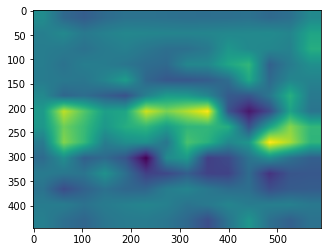

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

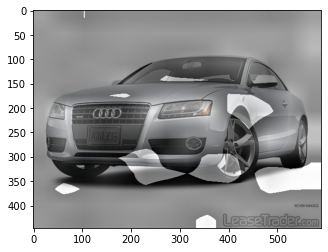

In [17]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

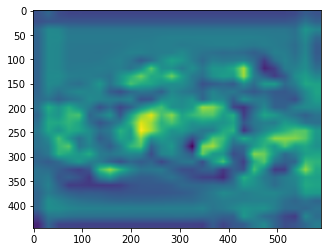

In [18]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

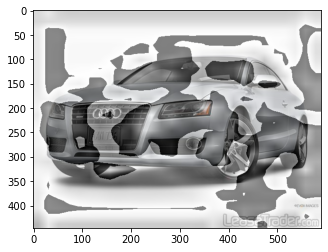

In [19]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 바운딩 박스 구하기

In [20]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [51]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ -5, 111],
       [586,  96],
       [593, 356],
       [  0, 371]])

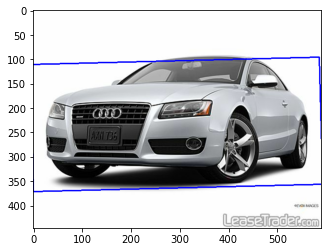

In [52]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

## IoU 구하기

In [53]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [54]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.21524663677130046,
 -0.00847457627118644,
 0.8318385650224215,
 1.005084745762712]

In [55]:
# Ground Truth
item['bbox']

array([0.20403588, 0.04576271, 0.7847534 , 0.9542373 ], dtype=float32)

In [56]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [57]:
get_iou(pred_bbox, item['bbox']) # 0.7401634900323132

0.8145994258076465

## 결과 비교하기

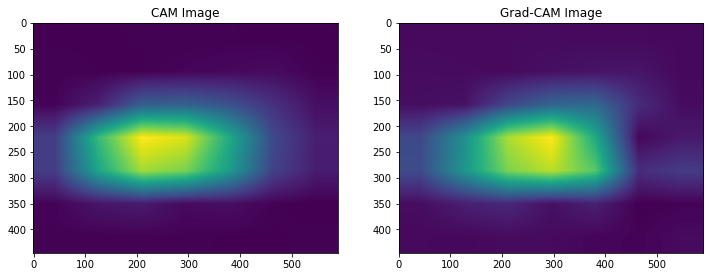

In [27]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_image)

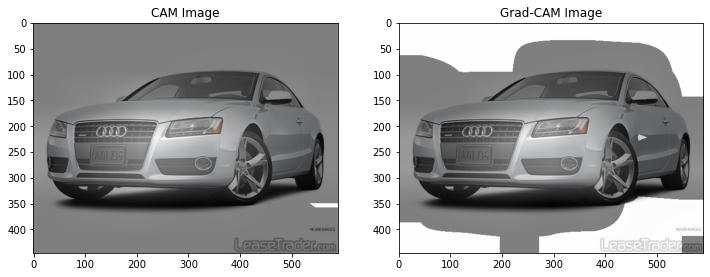

In [38]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_blended_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_blended_image)

In [46]:
cam_rect = get_bbox(cam_image)
grad_cam_rect = get_bbox(grad_cam_image)

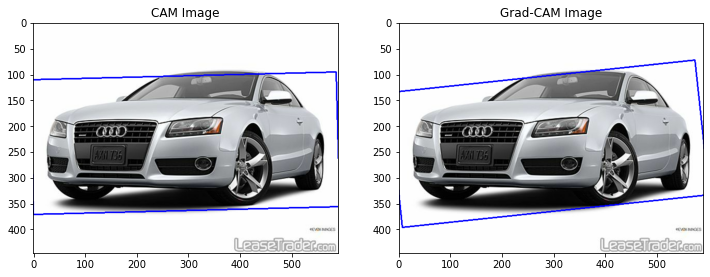

In [49]:
cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [cam_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [grad_cam_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_bbox_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

In [58]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])

In [87]:
cam_iou = get_iou(cam_pred_bbox, item['bbox'])
grad_cam_iou = get_iou(grad_cam_pred_bbox, item['bbox'])

In [88]:
print(f'CAM IoU : {cam_iou}')
print(f'Grad-CAM IoU : {grad_cam_iou}')

CAM IoU : 0.8145994258076465
Grad-CAM IoU : 0.6921025395733914


### 원본 이미지의 bounding box

In [82]:
y1 = int(item['image'].shape[0] * item['bbox'][0])
y2 = int(item['image'].shape[0] * item['bbox'][2])
x1 = int(item['image'].shape[1] * item['bbox'][1])
x2 = int(item['image'].shape[1] * item['bbox'][3])
orig_rect = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])

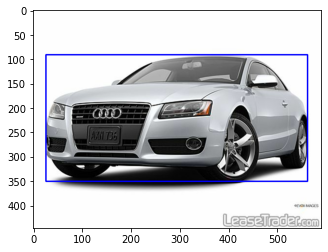

In [84]:
orig_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [orig_rect], 0, (0, 0, 255), 2)
plt.imshow(orig_bbox_image)

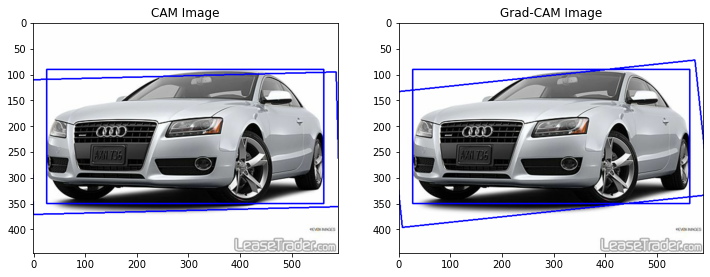

In [85]:
cam_bbox_image = cv2.drawContours(cam_bbox_image, [orig_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_image = cv2.drawContours(grad_cam_bbox_image, [orig_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_bbox_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

## 결과 확인
- IoU는 Grad-CAM보다 CAM이 더 높게 나왔다.
- 실제 이미지의 bbox를 시각화해보니 육안으로 봤을 때 CAM 이미지 쪽이 겹치는 부분이 더 많아보였다.

## 회고록

- CAM은 이론으로만 배워서 어떻게 하는지 궁금했는데 이번 노드를 통해서 배울 수 있게 되어서 좋았다.
- 앞에서 학습했던 여러가지 개념들을 잘 이해하고 있어야 이번 노드도 잘 학습할 수 있는 것 같다.
- CAM보다 Grad-CAM의 성능이 더 좋을 것으로 예상했는데 IoU를 비교해본 결과 CAM 쪽이 더 높은 것으로 나타났다. 이 부분에 대해서는 bounding box가 직사각형 형태로만 그려질 수 있어서 그런 것 같다.